In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             classification_report, f1_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import joblib
import os
import random

# Répétabilité
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [144]:
# Cellule 2 : Charger l'extension TensorBoard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [145]:
# Charger les données prétraitées
df = pd.read_csv("../data/Customers_cleaned.csv")

In [146]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [147]:
# Séparation features/target
y = (df['Churn'] == 'Yes').astype(int)
X = df.drop(['Churn', 'customerID'], axis=1)

# Définition des colonnes
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Création du preprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Split des données (train/val/test stratifié)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=SEED, stratify=y_temp
)

# Fit/transform sur train, transform sur val/test
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)

In [148]:
#Creation du MLP
#Définition des hyperparamètres

input_dim = X_train_prep.shape[1]
lr = 0.001
dropout = 0.3

In [149]:
#creation du modèle

inputs = layers.Input(shape=(input_dim,), name='tabular_input')
x= layers.Dense(128, activation='relu')(inputs)
x= layers.Dropout(dropout)(x)
x= layers.Dense(64, activation='relu')(x)
x= layers.Dropout(dropout)(x)
outputs= layers.Dense(1, activation='sigmoid')(x)


model = keras.Model(inputs, outputs, name='telco_mlp')
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=lr),
    loss = 'binary_crossentropy',
    metrics=[
        keras.metrics.AUC(name='auc'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.Precision(name='precision')
    ])

model.summary()

Model: "telco_mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tabular_input (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,161 (47.50 KB)

 Trainable params: 12,161 (47.50 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
#Entrainement du MLP
#Création des répertoires pour les checkpoints et les logs
checkpoints_dir= "checkpoints"
tensorboard_dir= "tensorboard_logs"
os.makedirs(checkpoints_dir, exist_ok= True)
os.makedirs(tensorboard_dir, exist_ok= True)


In [151]:
#Callbacks

cb_early_stopping = callbacks.EarlyStopping(
    monitor= "val_auc",
    patience=10,
    restore_best_weights= True,
    mode= 'max'
)

cb_checkpoint= callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoints_dir, 'best_model.keras'),
    monitor= "val_auc",
    save_best_only= True,
    mode= 'max'
)

cb_tensorboard= callbacks.TensorBoard(
    log_dir= tensorboard_dir,
    histogram_freq=1,
    write_graph= True,
    write_images= True
)


In [152]:
#Gestion du déséquilibre de classes
neg, pos = np.bincount(y_train)
class_weight= {0: 1.0, 1: neg/pos}

In [153]:
print("NaN dans X_train_prep :", np.isnan(X_train_prep).sum())
print("NaN dans X_val_prep :", np.isnan(X_val_prep).sum())
print("Inf dans X_train_prep :", np.isinf(X_train_prep).sum())
print("Inf dans X_val_prep :", np.isinf(X_val_prep).sum())

NaN dans X_train_prep : 0
NaN dans X_val_prep : 0
Inf dans X_train_prep : 0
Inf dans X_val_prep : 0


In [154]:
#Entrainement du modèle

batch_size = 32
history = model.fit(
    X_train_prep, y_train,
    validation_data=(X_val_prep, y_val),
    epochs= 100,
    batch_size=batch_size,
    callbacks= [cb_early_stopping, cb_checkpoint, cb_tensorboard],
    class_weight= class_weight,
    verbose = 2
)

Epoch 1/100
141/141 - 2s - 12ms/step - auc: 0.8072 - loss: 0.7873 - precision: 0.4883 - recall: 0.7508 - val_auc: 0.8442 - val_loss: 0.4914 - val_precision: 0.5270 - val_recall: 0.7826
Epoch 2/100
141/141 - 0s - 3ms/step - auc: 0.8338 - loss: 0.7384 - precision: 0.5170 - recall: 0.8010 - val_auc: 0.8479 - val_loss: 0.4999 - val_precision: 0.5084 - val_recall: 0.8094
Epoch 3/100
141/141 - 0s - 3ms/step - auc: 0.8408 - loss: 0.7228 - precision: 0.5135 - recall: 0.7960 - val_auc: 0.8482 - val_loss: 0.5027 - val_precision: 0.5020 - val_recall: 0.8227
Epoch 4/100
141/141 - 0s - 3ms/step - auc: 0.8418 - loss: 0.7233 - precision: 0.5173 - recall: 0.8018 - val_auc: 0.8472 - val_loss: 0.5001 - val_precision: 0.4990 - val_recall: 0.8127
Epoch 5/100
141/141 - 0s - 3ms/step - auc: 0.8441 - loss: 0.7170 - precision: 0.5125 - recall: 0.8043 - val_auc: 0.8475 - val_loss: 0.5038 - val_precision: 0.5020 - val_recall: 0.8194
Epoch 6/100
141/141 - 0s - 3ms/step - auc: 0.8469 - loss: 0.7095 - precision: 0

In [155]:
# Cellule 5 : Visualisation TensorBoard (à exécuter quand tu veux voir les logs)
%tensorboard --logdir tensorboard_logs

Reusing TensorBoard on port 6007 (pid 42464), started 0:00:13 ago. (Use '!kill 42464' to kill it.)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Performances du modèle MLP sur l'ensemble de validation :
ROC AUC : 0.8482
F1 Score : 0.6236

Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.71      0.80       828
           1       0.50      0.82      0.62       299

    accuracy                           0.74      1127
   macro avg       0.71      0.76      0.71      1127
weighted avg       0.81      0.74      0.75      1127



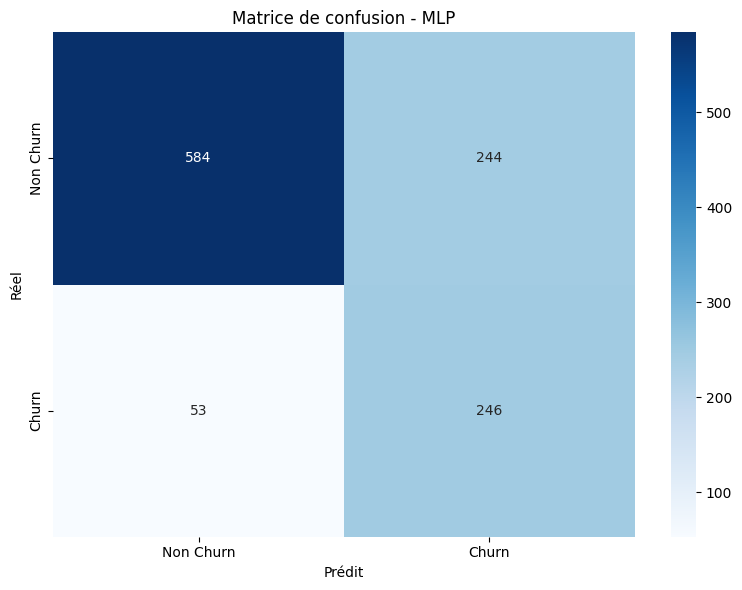

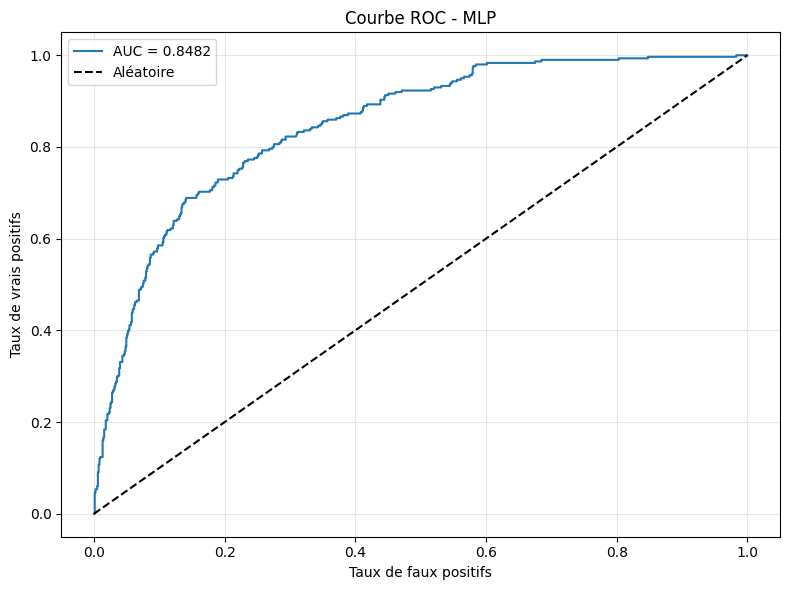

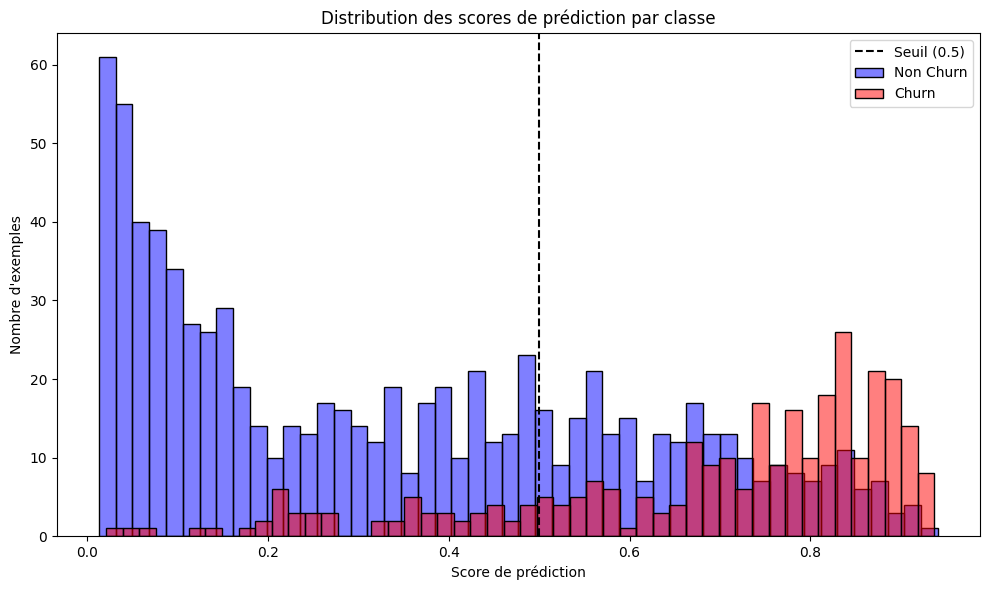

In [156]:
# Prédictions sur l'ensemble de validation
y_val_pred_proba = model.predict(X_val_prep).ravel()  # Aplatir les prédictions

# Vérifier et gérer les valeurs NaN
if np.isnan(y_val_pred_proba).any():
    print(f"Attention : {np.isnan(y_val_pred_proba).sum()} valeurs NaN détectées dans les prédictions.")
    # Remplacer les NaN par 0.5 (valeur neutre)
    y_val_pred_proba = np.nan_to_num(y_val_pred_proba, nan=0.5)

# Convertir en prédictions binaires
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

# Calcul des métriques
val_auc = roc_auc_score(y_val, y_val_pred_proba)
val_f1 = f1_score(y_val, y_val_pred)

# Affichage des métriques
print("Performances du modèle MLP sur l'ensemble de validation :")
print(f"ROC AUC : {val_auc:.4f}")
print(f"F1 Score : {val_f1:.4f}")
print("\nRapport de classification :")
print(classification_report(y_val, y_val_pred))

# Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Churn', 'Churn'],
            yticklabels=['Non Churn', 'Churn'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion - MLP')
plt.tight_layout()
plt.show()

# Courbe ROC
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {val_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Aléatoire')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - MLP')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution des scores de prédiction
plt.figure(figsize=(10, 6))
sns.histplot(y_val_pred_proba[y_val == 0], bins=50, alpha=0.5, label='Non Churn', color='blue')
sns.histplot(y_val_pred_proba[y_val == 1], bins=50, alpha=0.5, label='Churn', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil (0.5)')
plt.xlabel('Score de prédiction')
plt.ylabel('Nombre d\'exemples')
plt.title('Distribution des scores de prédiction par classe')
plt.legend()
plt.tight_layout()
plt.show()